# Some integration tests for cross correlation calculation

In [1]:
%matplotlib inline
import time
import timeit
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from types import SimpleNamespace
from typing import Sequence, Callable
from tqdm.notebook import tqdm

from bioslds.xcorr import OnlineCrosscorrelation
from bioslds.regressor_utils import to_hankel
from bioslds.plotting import FigureManager, colorbar

## Test autocorrelation on sinusoidal signal with varying frequency

In [2]:
vary_sine = SimpleNamespace(n_samples=10000, T0=7.0, T1=9.0, n_components=24, rate=0.01)
vary_sine.t = np.arange(vary_sine.n_samples)
vary_sine.w0 = 2 * np.pi / vary_sine.T0
vary_sine.w1 = 2 * np.pi / vary_sine.T1

# d/dt phi(t) = w0 + (w1-w0) * t/n --> phi(t) = w0 * t + 0.5 * (w1-w0) * t**2 / n
vary_sine.y0 = np.cos(
    vary_sine.w0 * vary_sine.t
    + 0.5 * (vary_sine.w1 - vary_sine.w0) * vary_sine.t ** 2 / vary_sine.n_samples
)

vary_sine.lag = to_hankel(vary_sine.y0, vary_sine.n_components)

vary_sine.y = vary_sine.y0[vary_sine.n_components :]
vary_sine.x = vary_sine.lag[vary_sine.n_components - 1 : -1]

vary_sine.xcorr = OnlineCrosscorrelation(vary_sine.n_components, rate=vary_sine.rate)
vary_sine.res = vary_sine.xcorr.transform(vary_sine.x, vary_sine.y, progress=tqdm)

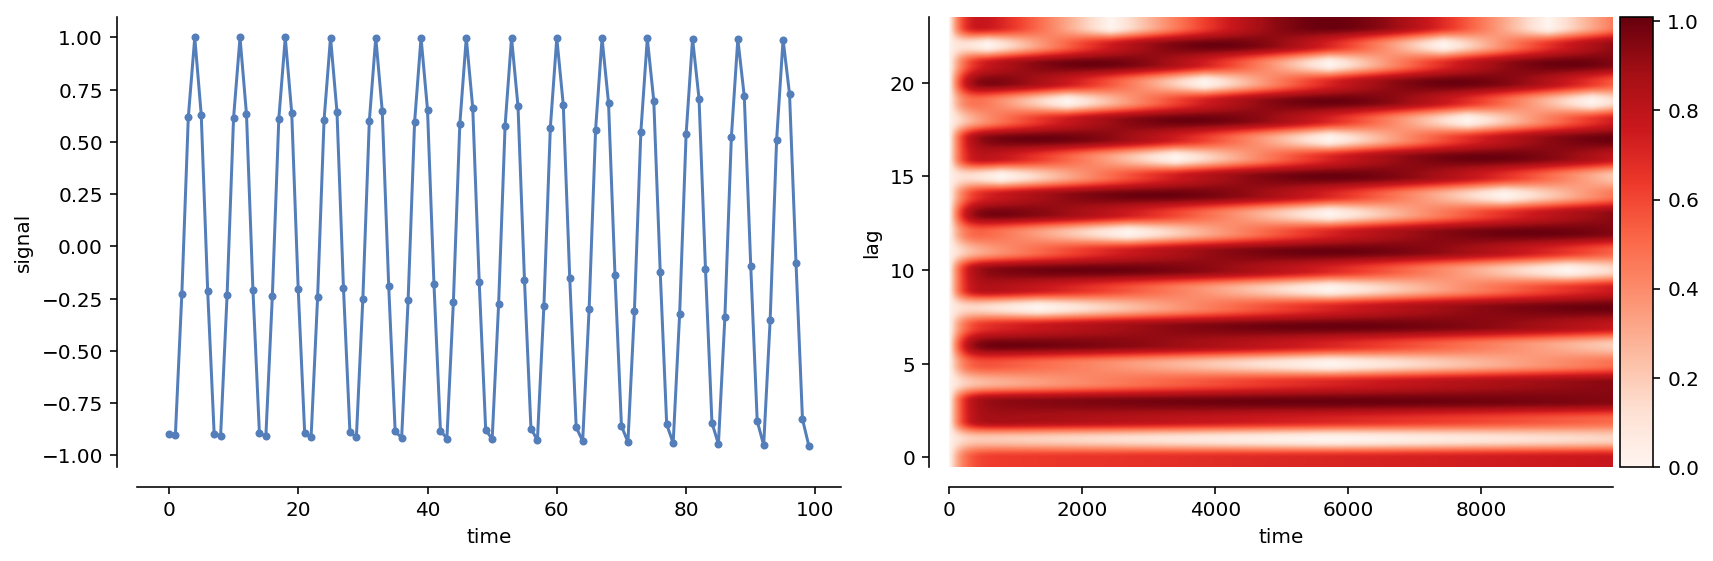

In [3]:
with FigureManager(1, 2) as (_, (ax1, ax2)):
    ax1.plot(vary_sine.t[:100], vary_sine.y[:100], ".-")
    ax1.set_ylabel("signal")
    ax1.set_xlabel("time")
    
    h = ax2.imshow(np.abs(vary_sine.res.T), aspect="auto", cmap="Reds", vmin=0)
    colorbar(h)
    ax2.invert_yaxis()
    ax2.set_xlabel("time")
    ax2.set_ylabel("lag")

## Benchmark `OnlineCrosscorrelation.transform` speed

In [4]:
def benchmark_xcorr(
    xcorr: OnlineCrosscorrelation,
    sample_sizes: Sequence,
    rng: np.random.Generator,
    progress: Callable = None,
    n_rep: int = 3,
):
    """ Benchmark speed of `OnlineCrosscorrelation.transform`.
    
    This runs `OnlineCrosscorrelation.transform` for different sample sizes,
    benchmarking the execution speed.
    
    Parameters
    ----------
    xcorr
        Cross-correlation object to benchmark.
    sample_sizes
        Sequence indicating which sample sizes to use.
    rng
        Random number generator for creating input data.
    progress
        Callable to track progress.
    n_rep
        Number of times to repeat the time measurement. The first time,
        `timeit`s `autorange` is used to determine a good number of
        iterations, then `repeat` is called with `n_rep - 1` repeats
        and `number` set to the count returned by `autorange`.
    
    Returns a tuple of arrays, `(sample_sizes, times)`, with the first
    element, `sample_sizes`, simply a clone of the input argument, and the
    second element, `times`, indicating the times (in seconds) it took to
    transform each of the data sets with sizes given by `sample_sizes`. The
    timings are obtained by potentially running the task many times, using
    the `autorange` member from `timeit.Timer`.
    """
    times = np.zeros(len(sample_sizes))
    if progress is None:
        progress = lambda it: it
    for i, n in enumerate(progress(sample_sizes)):
        crt_y = rng.normal(size=n)
        crt_x = rng.normal(size=(n, xcorr.n_components))
        timer = timeit.Timer(lambda: xcorr.transform(crt_x, crt_y))
        count, total_time = timer.autorange()

        other_times = timer.repeat(n_rep - 1, count)
        best_time = min(total_time, np.min(other_times))

        times[i] = best_time / count

    return sample_sizes, times

In [5]:
spd_params = SimpleNamespace(
    orders=[2, 25, 250], sample_sizes=np.geomspace(10, 100000, 10).astype(int),
)

rng = np.random.default_rng(1)
spd_results = {}
spd_all_modes = OnlineCrosscorrelation._available_modes
for crt_mode in tqdm(spd_all_modes, desc="mode"):
    for crt_order in tqdm(spd_params.orders, desc="order"):
        crt_xcorr = OnlineCrosscorrelation(n_components=crt_order, rate=0.01)
        crt_xcorr._mode = crt_mode
        crt_sizes, crt_times = benchmark_xcorr(
            crt_xcorr, spd_params.sample_sizes, rng, progress=tqdm
        )

        spd_results[crt_mode, crt_order] = {
            "xcorr": crt_xcorr,
            "sizes": crt_sizes,
            "times": crt_times,
        }

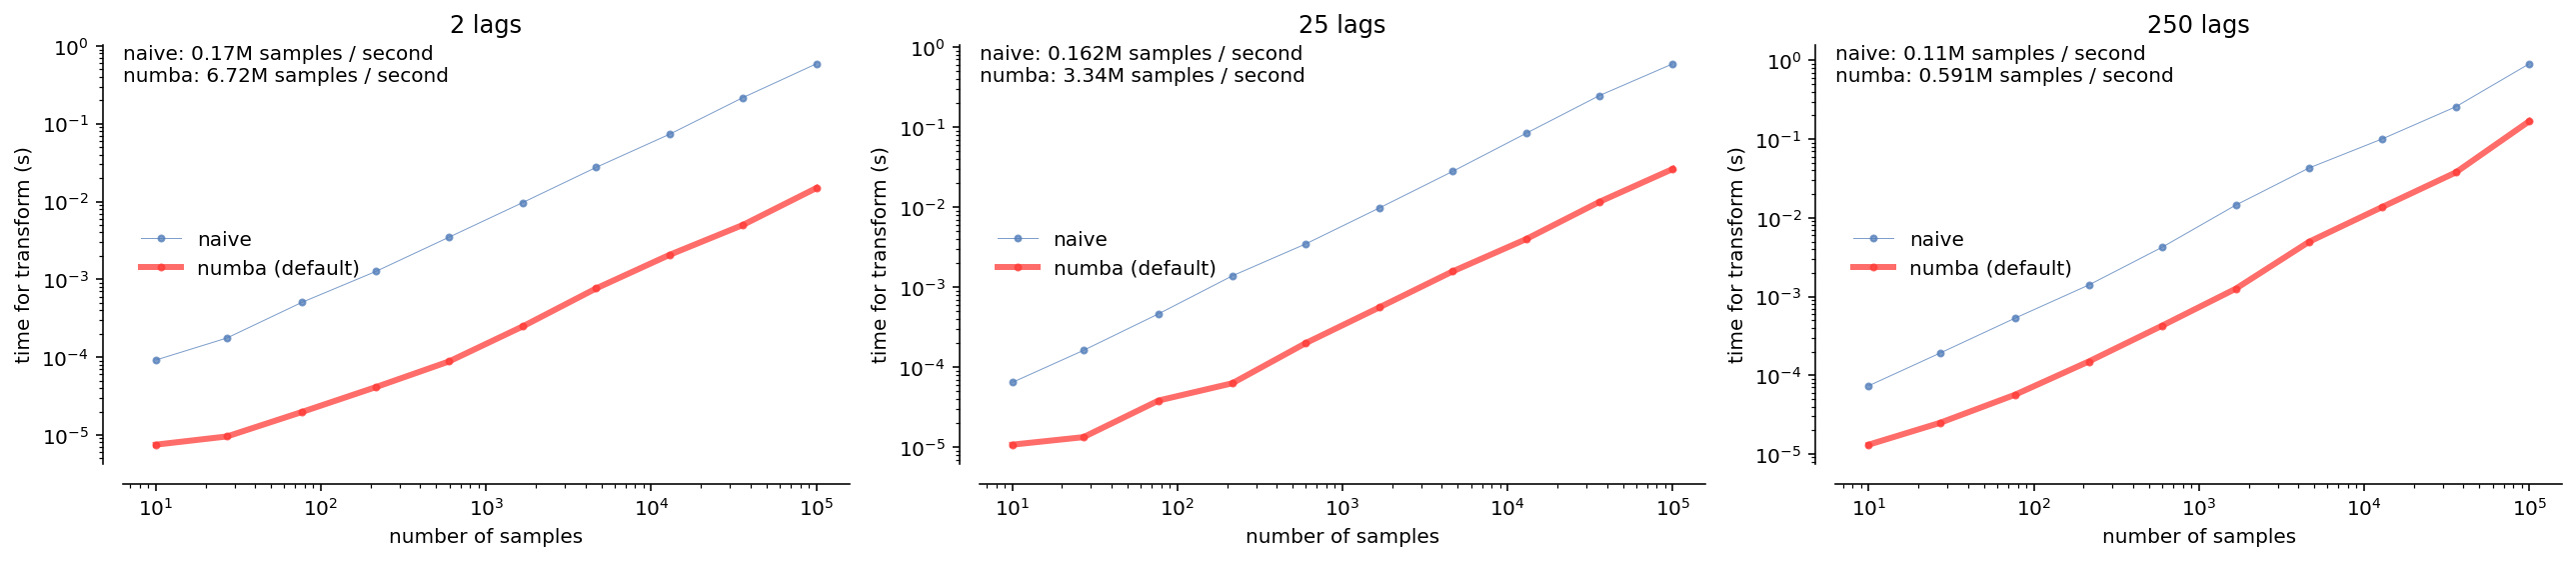

In [6]:
default_mode = OnlineCrosscorrelation(2)._mode

with FigureManager(1, len(spd_params.orders)) as (_, axs):
    for i, ax in enumerate(axs):
        crt_rates = []
        crt_annot_list = []
        for crt_mode in spd_all_modes:
            crt_order = spd_params.orders[i]
            crt_results = spd_results[crt_mode, crt_order]
            is_default = crt_mode == default_mode

            if not is_default:
                crt_label = crt_mode
            else:
                crt_label = crt_mode + " (default)"

            ax.loglog(
                crt_results["sizes"],
                crt_results["times"],
                ".-",
                label=crt_label,
                alpha=0.75,
                lw=3 if is_default else 0.5,
            )

            crt_rate = crt_results["sizes"][-1] / crt_results["times"][-1] / 1000000
            crt_rates.append(crt_rate)
            crt_annot_list.append(f"{crt_mode}: {crt_rate:.3g}M samples / second")

        ax.set_title(f"{crt_order} lags")
        ax.legend(frameon=False, loc="center left")

        ax.set_xlabel("number of samples")
        ax.set_ylabel("time for transform (s)")

        crt_annot = "\n".join(crt_annot_list)
        ax.annotate(
            crt_annot, (0.0, 1.0), xycoords="axes fraction", verticalalignment="top"
        )